## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.8, 0.6]
reduce_lr_patient = [4, 6]

In [8]:
from keras.callbacks import ReduceLROnPlateau
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0726 11:38:09.432896  4412 deprecation_wrapper.py:119] From c:\users\user\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 11:38:09.434895  4412 deprecation_wrapper.py:119] From c:\users\user\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 11:38:09.440903  4412 deprecation_wrapper.py:119] From c:\users\user\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 11:38:09.606019  4412 deprecation_wrapper.py:119] From c:\users\user\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Numbers of exp: 0, reduce_factor: 0.80, reduce_patient: 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 920,842
Trainable params: 920,842
Non-trainable params: 0
_________________________________________________________________


W0726 11:38:09.632047  4412 deprecation_wrapper.py:119] From c:\users\user\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0726 11:38:09.901240  4412 deprecation.py:323] From c:\users\user\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0726 11:38:10.050342  4412 deprecation_wrapper.py:119] From c:\users\user\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 173us/step - loss: 2.2526 - acc: 0.1667 - val_loss: 2.1623 - val_acc: 0.2306
Epoch 2/25
50000/50000 [==============================] - 6s 111us/step - loss: 2.0896 - acc: 0.2531 - val_loss: 2.0292 - val_acc: 0.2768
Epoch 3/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.9843 - acc: 0.2998 - val_loss: 1.9493 - val_acc: 0.3172
Epoch 4/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.9210 - acc: 0.3293 - val_loss: 1.8986 - val_acc: 0.3381
Epoch 5/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.8780 - acc: 0.3444 - val_loss: 1.8637 - val_acc: 0.3517
Epoch 6/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.8459 - acc: 0.3569 - val_loss: 1.8344 - val_acc: 0.3585
Epoch 7/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.8194 - acc: 0.3653 - val_loss: 1.8091 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 114us/step - loss: 2.2640 - acc: 0.1592 - val_loss: 2.1878 - val_acc: 0.2390
Epoch 2/25
50000/50000 [==============================] - 5s 103us/step - loss: 2.1157 - acc: 0.2622 - val_loss: 2.0446 - val_acc: 0.2846
Epoch 3/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.9928 - acc: 0.2999 - val_loss: 1.9498 - val_acc: 0.3112
Epoch 4/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.9182 - acc: 0.3253 - val_loss: 1.8967 - val_acc: 0.3381
Epoch 5/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.8741 - acc: 0.3449 - val_loss: 1.8621 - val_acc: 0.3464
Epoch 6/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.8436 - acc: 0.3555 - val_loss: 1.8343 - val_acc: 0.3578
Epoch 7/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.8180 - acc: 0.3648 - val_loss: 1.8138 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 132us/step - loss: 2.0417 - acc: 0.2497 - val_loss: 1.8726 - val_acc: 0.3307
Epoch 2/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.7921 - acc: 0.3608 - val_loss: 1.7184 - val_acc: 0.3876
Epoch 3/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.6890 - acc: 0.3985 - val_loss: 1.6571 - val_acc: 0.4068 1.70
Epoch 4/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.6280 - acc: 0.4205 - val_loss: 1.6127 - val_acc: 0.4249
Epoch 5/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.5911 - acc: 0.4346 - val_loss: 1.5624 - val_acc: 0.4449
Epoch 6/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.5350 - acc: 0.4535 - val_loss: 1.5224 - val_acc: 0.4609
Epoch 7/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.5091 - acc: 0.4615 - val_loss: 1.51

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 149us/step - loss: 2.6996 - acc: 0.1937 - val_loss: 1.9738 - val_acc: 0.2527
Epoch 2/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.9262 - acc: 0.2778 - val_loss: 1.8888 - val_acc: 0.2950
Epoch 3/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.8573 - acc: 0.3138 - val_loss: 1.8214 - val_acc: 0.3295
Epoch 4/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.7940 - acc: 0.3448 - val_loss: 1.7612 - val_acc: 0.3554
Epoch 5/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.7486 - acc: 0.3644 - val_loss: 1.7534 - val_acc: 0.3627
Epoch 6/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.7207 - acc: 0.3745 - val_loss: 1.7097 - val_acc: 0.3788
Epoch 7/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.6967 - acc: 0.3842 - val_loss: 1.6965 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 134us/step - loss: 2.7413 - acc: 0.1589 - val_loss: 2.2300 - val_acc: 0.1510
Epoch 2/25
50000/50000 [==============================] - 5s 109us/step - loss: 2.1222 - acc: 0.2234 - val_loss: 2.0105 - val_acc: 0.2508
Epoch 3/25
50000/50000 [==============================] - 5s 109us/step - loss: 2.0263 - acc: 0.2652 - val_loss: 1.9486 - val_acc: 0.2881
Epoch 4/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.9643 - acc: 0.2881 - val_loss: 1.8669 - val_acc: 0.3233
Epoch 5/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.9175 - acc: 0.3096 - val_loss: 1.8122 - val_acc: 0.3501
Epoch 6/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.8619 - acc: 0.3298 - val_loss: 1.7935 - val_acc: 0.3487
Epoch 7/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.8324 - acc: 0.3411 - val_loss: 1.7739 - 

50000/50000 [==============================] - 6s 110us/step - loss: 1.3404 - acc: 0.5250 - val_loss: 1.4292 - val_acc: 0.4930
Numbers of exp: 10, reduce_factor: 0.60, reduce_patient: 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 920,842
Trainable params: 920,842
Non-trainable params: 0
________________

Epoch 18/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.5293 - acc: 0.4562 - val_loss: 1.5595 - val_acc: 0.4455
Epoch 19/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.5192 - acc: 0.4573 - val_loss: 1.5866 - val_acc: 0.4344
Epoch 20/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.5055 - acc: 0.4687 - val_loss: 1.5830 - val_acc: 0.4299
Epoch 21/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.4886 - acc: 0.4695 - val_loss: 1.5351 - val_acc: 0.4528
Epoch 22/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.4767 - acc: 0.4740 - val_loss: 1.5354 - val_acc: 0.4598
Epoch 23/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.4656 - acc: 0.4806 - val_loss: 1.5145 - val_acc: 0.4575
Epoch 24/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.4524 - acc: 0.4846 - val_loss: 1.5154 - val_acc: 0.4618
Epoch 25/25
50000/50000 [==

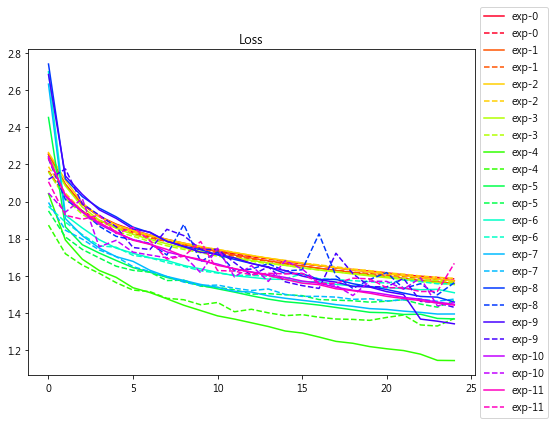

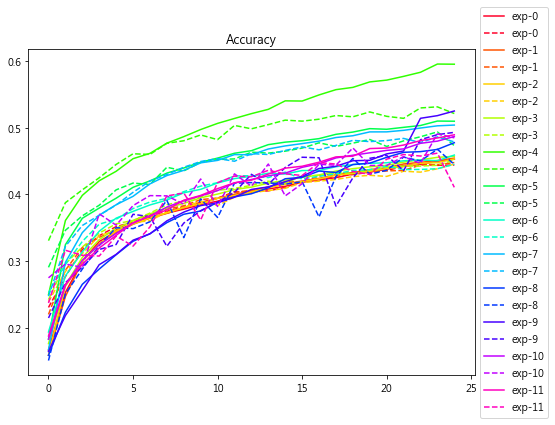

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

best result: Numbers of exp: 4, reduce_factor: 0.80, reduce_patient: 4, Adam